# [NLP - Exercise](https://fhict.instructure.com/courses/13057/assignments/219947)  <a name="EXER"></a>

## Relevant Modules
[NLP - How to apply?](https://fhict.instructure.com/courses/13057/pages/nlp-how-to-apply?module_item_id=921382) <br/>
[NLP - Theoretical background](https://fhict.instructure.com/courses/13057/pages/nlp-theoretical-background?module_item_id=921381)


## Description
You should now have a basic theoretical understanding of the elements in an NLP pipeline. And you should have some practice with several tutorials treating these new topics and methods.

Now the time is ripe to play with one of the state-of-the-art NLP pre-trained models, such as BERT (and derivatives such as ALBERT and RoBERTa), GPT-2,

1. Fine-tune a Tranformer model (use very little examples ~10-100): [Fine-tune a pretrained model](https://huggingface.co/docs/transformers/main/en/training) 
2. Apply the proper pipeline for inference and experiment with prompts: [Pipeline_tutorial](https://huggingface.co/docs/transformers/main/en/pipeline_tutorial) 

## Deliverable
A link/HTML/PDF of your (colab) notebook, make sure to document the code and explain your own steps. For extra kudos, you can change the model and task of the given tutorials. But beware, playing around with these large models is challenging and fine-tuning large models requires a lot of time and GPU power.



***


## Table of contents <a name="Table"></a>
- [Exercise statement](#EXER)
- [Table of contents](#Table)
- [Imports](#ENV)
    - [GPU](#GPU)    
- [Summarization](#SUMM)
    - [Data](#DATA)
    - [Model](#MODEL)
    - [Training](#TRAIN)
    - [Visualization](#VIS)
    - [Pipeline](#PIPE)
    - [Issues](#ISS)
    - [Sources](#SRC)




***


## Imports <a name="ENV"></a>

In [1]:
from datetime import datetime
import time
import random
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or {‘0’, ‘1’, ‘2’}

import tensorflow as tf
from tensorflow import keras

import torch

from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

import nltk
nltk.download('punkt')

import numpy as np
import pandas as pd

from IPython.display import display, HTML

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import seaborn as sns

######################

print(torch.__version__ + "-Torch")
print(tf.__version__ + "-TensorFlow/Keras")
print(torch.__version__+ "-PyTorch")
print(matplotlib.__version__+ "-Matplotlib")
print(pd.__version__+ "-Pandas")
print(np.__version__+ "-Numpy")

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.0.0+cu117-Torch
2.12.0-TensorFlow/Keras
2.0.0+cu117-PyTorch
3.7.1-Matplotlib
1.5.3-Pandas
1.23.5-Numpy


### GPU  <a name="GPU"></a>

In [2]:
print(torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0), torch.cuda.get_device_name(0))

True 1 0 <torch.cuda.device object at 0x7fd40c49edf0> NVIDIA GeForce RTX 2080


In [3]:
print(tf.test.is_built_with_cuda(), len(tf.config.list_physical_devices('GPU')))

True 1


***

## Summarization

### Data

Below we load the used dataset provided by the datasets library.

We also load in the metrics package ROUGE (Recall-Oriented Understudy for Gisting Evaluation) for evaluating the performance of the trained model.

In [4]:
raw_datasets = load_dataset("xsum")
metric = load_metric("rouge")

Found cached dataset xsum (/root/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71)
100%|██████████| 3/3 [00:00<00:00, 104.87it/s]
/tmp/ipykernel_39/4167283698.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


In [5]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

Here we can see the strucutre of our dataset. It is split into a train, validation and test -set consisiting of 204k, 11k & 11k entries respectively. All splits consist of feature columns containing the full document to be summarized, a summary that the model should aim for & an id.

In the section below we see the last entry in the trainingset.

In [6]:
raw_datasets["train"][-1]

{'document': 'The incident occurred at the headquarters of the Siam Commercial Bank in Bangkok on Sunday night.\nContract workers were upgrading the fire extinguisher system when a chemical retardant was released, apparently suffocating them.\nPolice are investigating how the system was set off.\nThe executives, Adisorn Pokha and Napong Suksanguan, are from a firm called Mega Planet, which had contracted out the work.\nThey face up to 10 years in prison if found guilty of negligence.\nPolice Lt Gen Sanit Mahathaworn said they had expressed regret and were willing to pay compensation for damages, according to the Bangkok Post.\nThe bank had said that an aerosol system called pyrogen was "inadvertently activated and exhausted all the oxygen in the area" as contractors were working on it.\nPyrogen involves a mixture of gases including potassium carbonates, nitrogen, carbon dioxide, carbon monoxide, nitrogen oxide and ammonia. The system works by removing all oxygen from the air to stifle 

In [7]:
shard_1 = raw_datasets["train"].shard(num_shards=5, index=0)
# shard_2 = raw_datasets["train"].shard(num_shards=4, index=1)
# shard_3 = raw_datasets["train"].shard(num_shards=4, index=2)
# shard_4 = raw_datasets["train"].shard(num_shards=4, index=3)

shard_1

Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 40809
})

Later during training we figure out that the dataset is way to large for longer training so we divided it into shards.

***
Below is an overview of the metric imported (ROUGE). 

Of particular interest in this project (and why rouge is used) are the "Rouge1", "Rouge2", "Rouge_L" & "Rouge_L_sum".

Rouge 1 refers to the overlap of unigrams between the generated summary and the reference summary. While Rouge 2 refers to the overlap of bigrams between the two summaries.

As I underdstand it this means in simple terms that rouge 1 checks how many words are in both summaries while rouge 2 checks for how many sequences (of 2) words are in both. There should also be a way to make the metric check for Rouge_n scores but it seems to be uncommon to go beyond roug_2 in other projects. Rouge_L is a score for the longest sequence that is in both summaries, the L is taken from "Longest Common Subsequence". The Rouge_L_Sum looks for the largest common sequence that can be made using both summaries.



In [8]:
metric 

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_aggregator: Return aggregates if this is set to True
Retu

In [9]:
fake_preds = ["hello there", "general kenobi"]
fake_labels = ["hello there", "general kenobi"]
metric.compute(predictions=fake_preds, references=fake_labels)

{'rouge1': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rouge2': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeL': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeLsum': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0))}

## Model

Below the model_checkpoint is defined. This will be used to load in the pretrained model. Several types were tried but due to constraints in my hardware I've chosen to use  t5-small which is already a fairly large model.

Its tokenizer is grabbed using AutoTokenizer from the Transformers package and we can see the attention_mask and tokens for some sentences (ToDo attention mask). 

In [10]:
model_checkpoint = "t5-small"  #["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [12]:
tokenizer("Hello, this one sentence!")

{'input_ids': [8774, 6, 48, 80, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [13]:
tokenizer(["Hello, this one sentence!", "This is another sentence."])

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

In [14]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Here the preprocessing is shown for an entry in the dataset as opposed to our own sentences above.

In [15]:
max_input_length = 1024
max_target_length = 128
prefix = "summarize: " #Since the model has multiple functionalities see: https://huggingface.co/t5-small

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [16]:
preprocess_function(shard_1[:2])

{'input_ids': [[21603, 10, 37, 423, 583, 13, 1783, 16, 20126, 16496, 6, 80, 13, 8, 844, 6025, 4161, 6, 19, 341, 271, 14841, 5, 7057, 161, 19, 4912, 16, 1626, 5981, 11, 186, 7540, 16, 1276, 15, 2296, 7, 5718, 2367, 14621, 4161, 57, 4125, 387, 5, 15059, 7, 30, 8, 4653, 4939, 711, 747, 522, 17879, 788, 12, 1783, 44, 8, 15763, 6029, 1813, 9, 7472, 5, 1404, 1623, 11, 5699, 277, 130, 4161, 57, 18368, 16, 20126, 16496, 227, 8, 2473, 5895, 15, 147, 89, 22411, 139, 8, 1511, 5, 1485, 3271, 3, 21926, 9, 472, 19623, 5251, 8, 616, 12, 15614, 8, 1783, 5, 37, 13818, 10564, 15, 26, 3, 9, 3, 19513, 1481, 6, 18368, 186, 1328, 2605, 30, 7488, 1887, 3, 18, 8, 711, 2309, 9517, 89, 355, 5, 3966, 1954, 9233, 15, 6, 113, 293, 7, 8, 16548, 13363, 106, 14022, 84, 47, 14621, 4161, 6, 243, 255, 228, 59, 7828, 8, 1249, 18, 545, 11298, 1773, 728, 8, 8347, 1560, 5, 611, 6, 255, 243, 72, 1709, 1528, 161, 228, 43, 118, 4006, 91, 12, 766, 8, 3, 19513, 1481, 410, 59, 5124, 5, 96, 196, 17, 19, 1256, 68, 27, 103, 317, 132

This process is then applied to the entire datset

In [17]:
raw_datasets["train"] = shard_1
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 40809
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [18]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

In [19]:
tokenized_datasets 

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 40809
    })
    validation: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 11334
    })
})

Now the trainer gets set up and the arguments for it are given. In the args below the standard input is used as defined inthe Seq2Seq documents.

### Training <a name="TRAIN"></a>

Here we load the t5-small model using the transformers library

In [20]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint) #t5-small

Here we define the arguments for the seq2seq trainer. No real changes from the defaults found in the huggingface documents, the batchsize is set at 8 for memory issues. 

In [21]:
batch_size = 8

model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    f"{model_name}-xsum",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    save_steps=10000,
    num_train_epochs=20,
    predict_with_generate=True,
    fp16=True,
)

In [22]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Below is the compute_metrics function as given on the huggingface source defined in sources

In [23]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Below the trainer gets created and the model, arguments, datasets, tokenizer and metrics function gets assigned to it. The next codeblock calls the training function so the model trains for 20 epochs.

In [26]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [27]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.766800,2.525391,27.499600,7.257700,21.570900,21.574800,18.831300
2,2.682800,2.478370,28.277500,7.745200,22.261200,22.269400,18.835900
3,2.653300,2.449222,28.617700,7.877500,22.542200,22.545900,18.834400
4,2.603000,2.429824,29.067200,8.192000,22.932000,22.932400,18.833900
5,2.579100,2.415305,29.223000,8.420300,23.127200,23.128500,18.802800
6,2.567700,2.402164,29.407800,8.507100,23.208700,23.204600,18.824700
7,2.547600,2.391815,29.370200,8.513800,23.231800,23.235800,18.824900
8,2.534100,2.384655,29.577900,8.667700,23.400300,23.404300,18.814800
9,2.502500,2.378544,29.764500,8.829700,23.587200,23.593100,18.828100
10,2.501600,2.372509,29.882400,8.845800,23.615700,23.620000,18.809600


TrainOutput(global_step=102040, training_loss=2.531716947806017, metrics={'train_runtime': 64482.7295, 'train_samples_per_second': 12.657, 'train_steps_per_second': 1.582, 'total_flos': 2.0107381115614003e+17, 'train_loss': 2.531716947806017, 'epoch': 20.0})

In [28]:
trainer.save_model("./manual_save/")

## Visualizations <a name="VIS"></a>

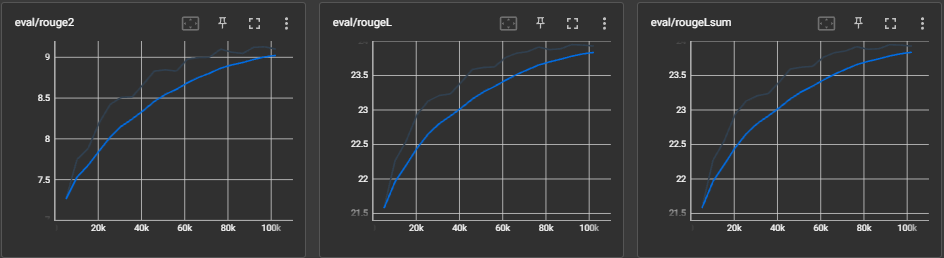
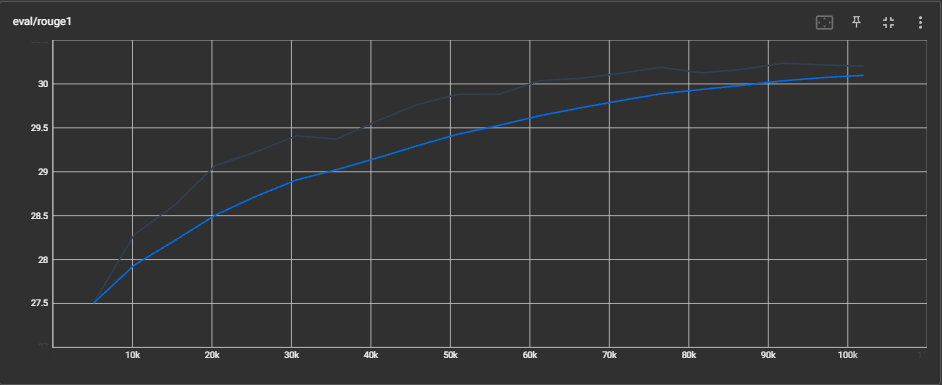

Above we can see the different ROUGE metrics go up during training. Implying that the model gets closer to the desired prewritten summary over the epochs

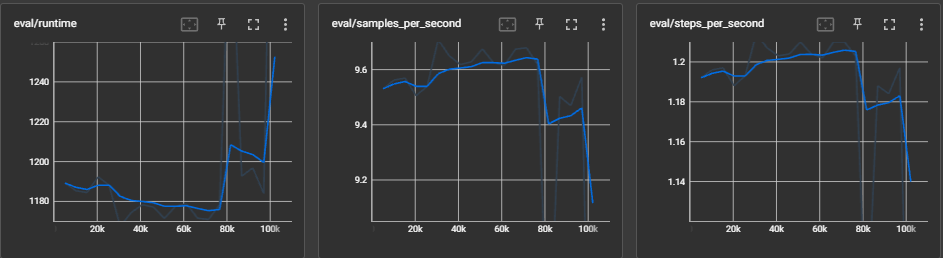

The less relevant plots above show that the training time per step goes up overtime but not in a smooth way

We can conclude, from the table and plots, that the model is succesfully finetuned.

## Pipeline <a name="PIPE"></a>



In [2]:
# Loading the finetuned model

generator = pipeline(model="./t5-small-xsum/runs/manual_save/", task="summarization", max_length=1024)

***

In [3]:
text = """
Turkey's all-powerful President Erdogan is in the fight of his life against an opposition that has united against him for Sunday's elections.

His main rival Kemal Kilicdaroglu appeared before a throng of supporters on Friday, flanked by allies from across the political spectrum who have come together as never before.

As the rain beat down in Ankara, he vowed to restore "peace and democracy".

The man he wants voters to oust after 20 years - Recep Tayyip Erdogan - said he had kept Turkey standing tall despite many challenges, including the economy with its rampant inflation and February's catastrophic double earthquakes.

Both issues have dominated this febrile campaign for both the presidency and parliament.

At 74, the opposition leader is often described as soft-spoken, but he gave a powerful speech to an audience that believes this is their best hope so far of reclaiming power from a president who has dramatically increased his own at the expense of parliament.

Mr Kilicdaroglu is slightly ahead in the opinion polls and his supporters have dared to dream he might win outright on Sunday, with more than 50% of the vote, rather than face a run-off two weeks later.

Firat, one of five million first-time voters, said he was delighted at conservatives and nationalists appearing on the same platform as the head of the centre-left Republican People's Party (CHP).

Here was nationalist Meral Aksener, the only female leader in the six-strong alliance, and there was Temel Karamollaoglu, who fronts the pro-Islamist Felicity party.

Mr Kilicdaroglu's party is secular to the core, but he has worked hard to reach out to women who wear the headscarf. The six parties have rallied under the slogan Haydi (Come on!) and a campaign song of the same name.


Tensions are running so high ahead of the vote that he wore a bullet-proof vest on stage in Ankara for his final rally and at another event earlier on.

The race has become as tense as it is pivotal. One of the four candidates for the presidency, Muharrem Ince, pulled out on Thursday, complaining that he had been targeted on social media with deepfake sex videos that had "manipulated the electorate".

When the main opposition challenger blamed Russia, the Kremlin denied having anything to do with the videos or seeking to interfere in the vote.

Mr Erdogan, who has maintained ties with Vladimir Putin, warned his rival: "If you attack Putin, I will not be ok with that."

The president was addressing party loyalists in Istanbul, but the night before he was just outside the capital in a city of half a million people that seemed in full support of his AK Party.

Orange, blue and white party AKP flags fluttered throughout the centre of Sincan, as locals filled the streets in the hope of catching a glimpse of Mr Erdogan.

Supporters chanted party songs as they waited for the president to show on stage in a green jacket. One chorus rang out repeatedly Re-cep Tay-yip Er-do-gaaaan.

"We built schools, universities and hospitals... we changed the face of our cities. We extracted our own natural gas and oil," Erdogan told thousands of cheering supporters.

His strategy, first as prime minister but then as president, has been to build growth, often through big-ticket construction projects that are visible in many of the big cities, but not so obvious in Sincan.

Although his party still commands strong support, he relies on the backing of the nationalist MHP and other smaller groups in his People's Alliance.

His greatest support comes mainly from conservative or nationalist Turks, and he has aimed his rhetoric not just at the West, which he accuses of going against him, but at the LGBT community too.

"The AK Party does not allow LGBT people into its neighbourhood, and the MHP does not allow them into the People's Alliance, because we believe in the sanctity of a family."

These political alliances have become essential under Turkey's political system as a party needs 7% of the national vote to get into parliament, or be part of an alliance that does.

Whoever wins the presidency will need to have sufficient support in parliament to back their plans.

On the campaign trail in Ankara, centre-left candidate Aysun Palali Koktas said that while the economy and the aftermath of the earthquake were the top two issues of the election, the future of Turkey's democracy and people's rights were just as important.

"When we tweet, we don't want to be frightened, and that's the case especially for young people," she said.

But, AK Party candidate Zehranur Aydemir, 25, believes young voters are very well treated by the government. "You can see young people at every level in our party."

More than 64 million people are expected vote at home and abroad on Sunday.

To win outright a candidate will have to secure more than half the vote.

If no candidate gets at least 50% plus one vote in the first round, the presidential election will go to a second round on 28 May between the two who received the most votes.
""" # https://www.bbc.com/news/world-europe-65568647

generator(text)



Token indices sequence length is longer than the specified maximum sequence length for this model (1181 > 512). Running this sequence through the model will result in indexing errors


[{'summary_text': "Turkey's president Recep Tayyip Erdogan has vowed to restore peace and democracy, but he has vowed to win outright on Sunday."}]

A fairly decent summary although restore might be better replaced with respect or keep.


***

In [4]:
generator("""Five funny features feel fairly finished for forum fodder, foolish followers falsely fancy, 
for failing further focus fueling full foresight, fellow fiction fanciers frankly forget fundamental facts framing fruits from frenzied freelancing, 
for first fragments flowing from frantic freshman fingers frequently fall flat, forming forced, flawed fakeries feigning fluency, faded facsimiles fractionally 
fitting for fatuous Facebook flapdoodle, familiar formulaic fragments famously fouling friends' feeds; fine, for furthermore, fascinatingly, 
first forays facing far-flung fringe frontiers, finding faith's fortitude ferociously fighting formidable foes—fear, frustration, flaky functioning, 
foot fungus—forge foundations for future feats, figurative furniture for fortune's foyer, faintly favoring fantastic fairytale fates, fervently foremost finally finishing forever.""")

Your max_length is set to 1024, but you input_length is only 209. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=104)


[{'summary_text': "The flurry of feigning feigns and feigning feigns is a stale tale, but it's a stale tale that's a bit of a stale tale."}]

Doesn't continue the tautogram sadly enough.

***

In [5]:
text = """Wind turbines have generated more electricity than gas for the first time in the UK.

In the first three months of this year a third of the countrys electricity came from wind farms, research from Imperial College London has shown.

National Grid has also confirmed that April saw a record period of solar energy generation.

By 2035 the UK aims for all of its electricity to have net zero emissions.

"There are still many hurdles to reaching a completely fossil fuel-free grid, but wind out-supplying gas for the first time is a genuine milestone event," said Iain Staffell, energy researcher at Imperial College and lead author of the report.

The majority of the UK's wind power has come from offshore wind farms. Installing new onshore wind turbines has effectively been banned since 2015 in England.

Under current planning rules, companies can only apply to build onshore wind turbines on land specifically identified for development in the land-use plans drawn up by local councils. Prime Minister Rishi Sunak agreed in December to relax these planning restrictions to speed up development.

Scientists say switching to renewable power is crucial to curb the impacts of climate change, which are already being felt, including in the UK, which last year recorded its hottest year since records began.

Solar and wind have seen significant growth in the UK. In the first quarter of 2023, 42% of the UK's electricity came from renewable energy, with 33% coming from fossil fuels like gas and coal.

But BBC research revealed on Thursday that billions of pounds' worth of green energy projects are stuck on hold due to delays with getting connections to the grid.

Some new solar and wind sites are waiting up to 10 to 15 years to be connected because of a lack of capacity in the electricity system.

And electricity only accounts for 18% of the UK's total power needs. There are many demands for energy which electricity is not meeting, such as heating our homes, manufacturing and transport.

Currently the majority of UK homes use gas for their heating - the government is seeking to move households away from gas boilers and on to heat pumps which use electricity.
""" #https://www.bbc.com/news/science-environment-65557469
          
generator(text)

Your max_length is set to 1024, but you input_length is only 443. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=221)


[{'summary_text': "The UK's wind power has been a record high in the last three months of this year, according to a new report. -"}]

I feel like the first sentence of the article should be included in the summary.

***

In [6]:
generator("Lorem ipsum")

Your max_length is set to 1024, but you input_length is only 9. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


[{'summary_text': 'A symphony of a symphony has been rediscovered by the British Museum of Art. '}]

Getting a very small piece of text makes the model generate (garbage) text, even though this is not its task 

...

***

## Issues <a name="ISS"></a>

Training time, as can be seen in the screenshot below using the whole dataset made for a very long training time over one epoch. The found solution was to use shards making the dataset significantly smaller.

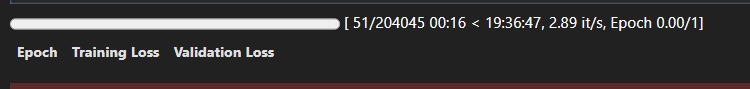

***

Memory on GPU (8GB), while trying to improve the training time I also tried larger batchsizes, this leads to having memory issues on my GPU (as can be seen below). The solution was to keep the batchsizes as is and accept the longer training time (and use shards).

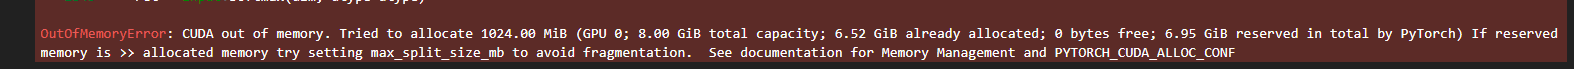

***

## Sources <a name="SRC"></a>

### Summarization:

[Metrics-Huggingface](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Metric)

[Rouge](https://www.freecodecamp.org/news/what-is-rouge-and-how-it-works-for-evaluation-of-summaries-e059fb8ac840/)

https://github.com/huggingface/transformers/blob/v4.29.1/src/transformers/training_args_seq2seq.py#L30

https://pytorch.org/docs/stable/tensorboard.html

https://huggingface.co/docs/datasets/index

https://huggingface.co/docs/datasets/process

https://huggingface.co/docs/datasets/v2.12.0/en/package_reference/main_classes#datasets.Dataset

https://github.com/huggingface/transformers

https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html

https://www.youtube.com/watch?v=q1TNpbPq3vY

https://www.youtube.com/watch?v=TsfLm5iiYb4

https://www.youtube.com/watch?v=QEaBAZQCtwE

https://www.youtube.com/watch?v=TsfLm5iiYb4

https://www.youtube.com/watch?v=Yo5Hw8aV3vY

#### Other:

[SNS docs heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

[Heatmap](https://www.youtube.com/watch?v=URbyDKfQT0Y)

[Mirrored images matplot](https://matplotlib.org/stable/tutorials/intermediate/imshow_extent.html)

[Rotate images matplot](https://stackoverflow.com/questions/31401812/matplotlib-rotate-image-file-by-x-degrees)

[EMNIST dataset](https://www.tensorflow.org/datasets/catalog/emnist)

[EMNIST research paper](https://arxiv.org/pdf/1702.05373v2.pdf)

[TensorFlow documentation, MNIST classification](https://www.tensorflow.org/tutorials/keras/classification)

[Tensorflow docs; loading Fasion_MNIST](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data)

[Numpy reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)

